# Dear ML Model: what is 2 x 3?

This notebook shows how ML models can learn to approximately multiply two numbers, even when the training data is noisy.

### Basics

A typical ML task is to estimate a function $f$ 
$$
    y = f(x_1, x_2, \dots) + \varepsilon
$$
as good as possible by $\hat f$ from data. Afterward, we can use $\hat f$ to 

- gain insights on the relationship between $x_i$ and $y$ and
- to make predictions based on $x_i$.

The specific steps to find $\hat f$ depend on the assumed structural form of $f$ and the optimization algorithm used to determine $\hat f$. 

### Some examples

- **Linear regression**: $f$ is assumed to be linear in its parameters and $\hat f$ is found by least-squares.
- **Generalized linear model**: $g(f)$ is linear and $\hat f$ is found by iteratively reweighted least-squares.
- **Neural net**: $f$ is a composition of linear and non-linear functions, found by gradient descent.
- **Decision tree**: $f$ is a binary decision tree, i.e. a collection of yes/no questions calculated by recursion.
- **Random forest**: $f$ is the average of randomized decision trees.
- **Gradient boosting**: $f$ is the average of decision trees, calculated sequentially. Each tree tries to fix the mistakes of the previous ones.

### Outlook

In this notebook, we will use neural nets and gradient boosting to learn noisy multiplication of two numbers $x_1$ and $x_2$, i.e.
$$
    y = f(x_1, x_2) + \varepsilon = x_1 \cdot x_2 + \varepsilon, 
$$
with $\varepsilon\sim N(0,1)$.

## Generate noisy data

Let's generate one million independent observations of above random process.

In [1]:
# Load modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

,x1,x2,y
0,-1.427959,-0.909703,2.914672
1,2.521623,-3.973049,-9.736590
2,1.307314,-1.002808,-1.534397
3,-6.998346,-0.479178,3.621836
4,-5.852353,-1.723083,10.453152


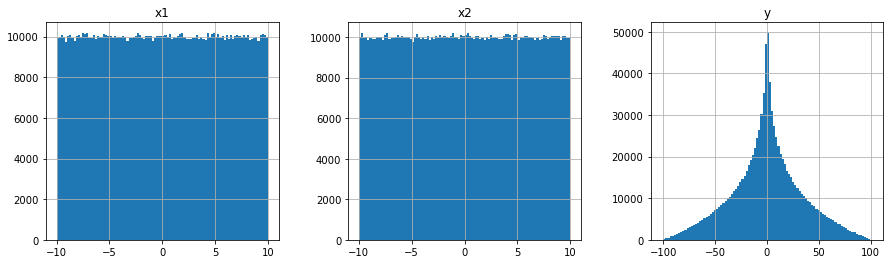

In [3]:
# Generate n observations
np.random.seed(1901)
n = 1_000_000 # 10_000_000

df = pd.DataFrame(np.random.uniform(-10, 10, size=(n, 2)), 
                  columns=['x1', 'x2'])
df['y'] = df.x1 * df.x2 + np.random.normal(scale=1, size=(n, ))

# Visualize
df.hist(bins=100, layout=(1, 3), figsize=(15, 4))
df.head()

### Training/Validation split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop('y', axis=1), 
    df['y'], 
    train_size=0.9, 
    random_state=525
)

## Neural Net

Can a neural net predict the result of the (noisy) multiplication $y$ given $x_1$ and $x_2$?

We start with the most simple neural net (no hidden layers) and then, step by step, add more neurons and/or more hidden layers. 
To do so, we rely on Google's [Keras/Tensorflow](https://www.tensorflow.org/guide/keras/sequential_model?hl=en).

It is up to you, dear user, to select the specific architecture. 

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

# Plot history (dropping the first m burn-in epochs)
def plot_history(h, drop_m=0):
    h = pd.DataFrame(h.history.history)
    h['epoch'] = np.arange(len(h.index)) + 1
    h = h.iloc[drop_m:]
    plt.plot(h.epoch, h.loss, label='Training')
    plt.plot(h.epoch, h.val_loss, label='Validation')
    plt.legend()
    
# Callbacks
early_stop = EarlyStopping(patience=10, mode='min')
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.2)
cb = [early_stop, reduce_lr]

### Architecture

In [23]:
# Neural net structure (play with architecture)
def fresh_neural_net():
    inputs = Input(shape=(2, ))
    x = Dense(20, activation='tanh')(inputs)
    output = Dense(1, activation='linear')(x)
    m = Model(inputs=inputs, outputs=output)
    m.compile(loss='mse', optimizer=Nadam(lr=0.05))
    return m

# Create new net
neural_net = fresh_neural_net()
neural_net.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


### Stochastic gradient descend until performance stops improving

In [24]:
neural_net.fit(
    X_train,
    y_train,
    batch_size=10000, 
    epochs=1000, 
    validation_data = (X_valid, y_valid),
    callbacks=cb,
    verbose=0
)

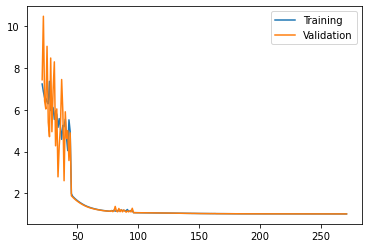

In [26]:
plot_history(neural_net, 20)

### Test model

In [ ]:
neural_net.predict([[-3, -8]])

### Extrapolation with numbers outside [-10, 10]?

In [ ]:
neural_net.predict([[4, 40]])

The model works, but only within the range of samples available. Extrapolation is not possible without clever "feature engineering".

## Gradient boosting

Neural nets are especially successful with text, image, and sound data. For tabular data, other methods like gradient boosting are often better and easier to use. However, since the normal person has never heard of gradient boosting, it is easier to mention neural nets if someone asks about what we do...

Here, we fit a [LightGBM model](https://lightgbm.readthedocs.io/en/latest), an increadible gradient boosting algorithm implementation by Microsoft.

In [6]:
import lightgbm as lgb

# Internal data handler
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

# Parameters
params = {
    'learning_rate': 0.2,
    'num_leaves': 63,
    'min_child_samples': 100,
    'objective': 'mse'
}

# Fit until validation performance starts to deteriorate
fit = lgb.train(
    params, 
    train_set=dtrain,
    early_stopping_rounds=50,
    num_boost_round=10000,
    valid_sets=dvalid,
    verbose_eval=100
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 1.2256
[200]	valid_0's l2: 1.12182
[300]	valid_0's l2: 1.08861
[400]	valid_0's l2: 1.07206
[500]	valid_0's l2: 1.06404
[600]	valid_0's l2: 1.05984
[700]	valid_0's l2: 1.05757
[800]	valid_0's l2: 1.05609
[900]	valid_0's l2: 1.05538
[1000]	valid_0's l2: 1.05505
[1100]	valid_0's l2: 1.0548
[1200]	valid_0's l2: 1.05462
Early stopping, best iteration is:
[1181]	valid_0's l2: 1.05457


In [ ]:
fit.predict([[-3, -8]])

### Extrapolation with numbers outside [-10, 10]?

In [ ]:
fit.predict([[20, 3]])

## Why is reality trickier?
- More than two input variables
- Missing values
- Data errors and gross outliers
- Special data structure (clusters, time series, spatial, ...)
- Extrapolation
- Explainability